https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.hamiltonians.ElectronicEnergy.html

### The electronic energy Hamiltonian

In [14]:
import numpy as np
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms import NumPyMinimumEigensolver

In [16]:
driver = PySCFDriver(
    atom=f"H 0 0 0",
    basis="sto3g",
    charge=0,
    spin=1,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()
mapper = JordanWignerMapper()

fermionic_op = problem.hamiltonian.second_q_op()

qubit_op = mapper.map(fermionic_op)

In [17]:
hamiltonian = problem.hamiltonian
coefficients = hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
array([[-0.46658185]])
 "++--":
array([0.77460594])


In [2]:
# assuming you already have your one- and two-body integrals from somewhere
# h1_a, h2_aa, h1_b, h2_bb, h2_ba = ...

h1_a = np.array([[-0.46658185, 0          ],
                 [ 0         , -0.46658185]])


h2_aa = np.array([[[[0.77460594, 0         ], [0         , 0         ]],
                   [[0         , 0         ], [0.77460594, 0         ]]],
                  [[[0         , 0.77460594], [0         , 0         ]],
                   [[0         , 0         ], [0         , 0.77460594]]]])


h1_a = np.array([[-0.5]])
h2_aa = np.zeros((1, 1, 1, 1))


# -1.8654161073242188

h1_b = h1_a
h2_bb = h2_aa

h2_ba = h2_aa


from qiskit_nature.second_q.operators import ElectronicIntegrals, PolynomialTensor

alpha = PolynomialTensor({"+-": h1_a, "++--": h2_aa})
beta = PolynomialTensor({"+-": h1_b, "++--": h2_bb})
beta_alpha = PolynomialTensor({"++--": h2_ba})

integrals = ElectronicIntegrals(alpha, beta, beta_alpha)

Las listas h1_a, h1_b, h2_aa, h2_bb, y h2_ba son matrices que representan las integrales electrónicas de un sistema cuántico o molecular. El tamaño de estas matrices depende de la cantidad de orbitales atómicos en el sistema y de cómo se están representando las interacciones entre estos orbitales.

1. h1_a y h1_b: Estas son matrices de un solo cuerpo que representan las integrales de energía cinética y potencial para los orbitales atómicos del sistema. Ambas matrices son de tamaño 2x2, ya que cada fila y columna corresponde a un orbital atómico en el sistema. Por ejemplo, h1_a[0, 0] representa la integral de energía cinética para el primer orbital atómico de A.

1. h2_aa y h2_bb: Estas son matrices de dos cuerpos que representan las interacciones electrón-electrón dentro del mismo conjunto de orbitales atómicos (A-A o B-B). Ambas matrices son de tamaño 2x2x2x2, ya que hay dos índices para los orbitales atómicos en A o B. Por ejemplo, h2_aa[0, 0, 0, 0] representa la interacción electrón-electrón entre el primer orbital atómico de A y el primer orbital atómico de A.

1. h2_ba: Esta es una matriz de dos cuerpos que representa las interacciones electrón-electrón entre orbitales atómicos de diferentes conjuntos (B-A). Esta matriz también es de tamaño 2x2x2x2, ya que hay dos índices para los orbitales atómicos en B y A. Por ejemplo, h2_ba[0, 0, 0, 0] representa la interacción electrón-electrón entre el primer orbital atómico de B y el primer orbital atómico de A.

En resumen, los tamaños de estas matrices se derivan de la cantidad de orbitales atómicos en el sistema y de cómo se están modelando las interacciones entre estos orbitales en el contexto de las integrales electrónicas del sistema.

In [3]:
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy

hamiltonian = ElectronicEnergy(integrals, constants={"nuclear_repulsion_energy": 0.01})

In [4]:
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=2, number terms=2
  -0.5 * ( +_0 -_0 )
+ -0.5 * ( +_1 -_1 )


In [5]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA

mapper = JordanWignerMapper()
fermionic_op = hamiltonian.second_q_op()
qubit_op = mapper.map(fermionic_op)

# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

seed = 170
algorithm_globals.random_seed = seed
noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 2**11},
    transpile_options={"seed_transpiler": seed},
)

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)

result_vqe = vqe.compute_minimum_eigenvalue(operator=qubit_op)

Text(0.5, 1.0, 'Convergence with no noise')

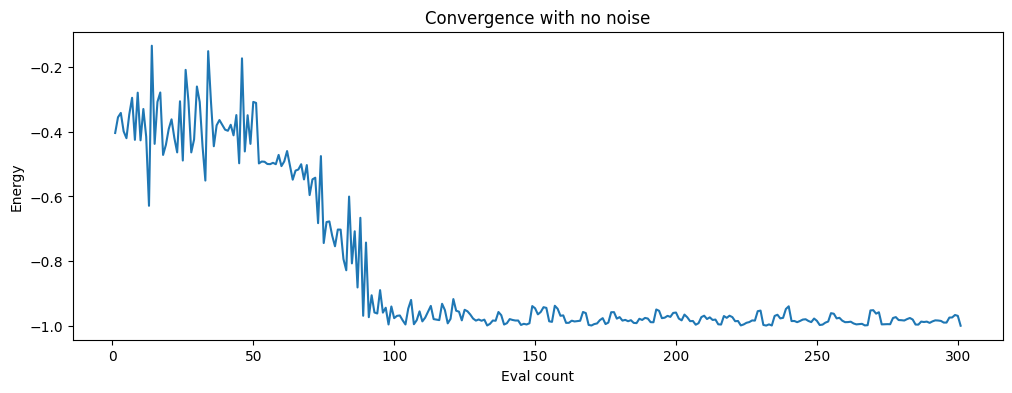

In [6]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

In [7]:
result_vqe.eigenvalue.real

-1.0

Note, how we specified the nuclear repulsion energy as a constant energy offset in the above examples. This term will not be included in the mapped qubit operator since it is a constant offset term and does not need to incur any errors from being measured on a quantum device. It is however possible to include constant energy terms inside of the ElectronicIntegrals container, if you want it to be included in the qubit operator, once mapping the second-quantized operator to the qubit space (see also QubitMapper).

In [8]:
from qiskit_nature.second_q.operators import PolynomialTensor

e_nuc = hamiltonian.nuclear_repulsion_energy
hamiltonian.electronic_integrals.alpha += PolynomialTensor({"": e_nuc})
hamiltonian.nuclear_repulsion_energy = None

It is also possible to add other constant energy offsets to the constants attribute of this Hamiltonian. All offsets registered in that dictionary will not be mapped to the qubit operator.

In [9]:
hamiltonian.constants["my custom offset"] = 5.0

# be careful, the following overwrites the hamiltonian.nuclear_repulsion_energy value
hamiltonian.constants["nuclear_repulsion_energy"] = 10.0

https://quri-parts.qunasys.com/tutorials/quantum_chemistry/mo_eint_and_hamiltonian

In [10]:
from pyscf import gto

h2o_atom_list = [['H', [0, 0, 0]], ['H', [0, 0, 0.735]]]
h2o_mol = gto.M(atom=h2o_atom_list, spin=0, verbose = 0)

In [11]:
from pyscf import scf

h2o_mf = scf.RHF(h2o_mol).run()
h2o_mo_coeff = h2o_mf.mo_coeff  # The MO coefficient of the H2O molecule.

In [12]:
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole

full_space, mo_eint_set = get_spin_mo_integrals_from_mole(h2o_mol, h2o_mo_coeff)

In [13]:
nuclear_energy = mo_eint_set.const
mo_1e_int = mo_eint_set.mo_1e_int.array
mo_2e_int = mo_eint_set.mo_2e_int.array

In [14]:
mo_1e_int

array([[-1.25633907e+00+0.j,  0.00000000e+00+0.j, -1.37083854e-17+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -1.25633907e+00+0.j,  0.00000000e+00+0.j,
        -1.37083854e-17+0.j],
       [-6.07732712e-17+0.j,  0.00000000e+00+0.j, -4.71896007e-01+0.j,
         0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -6.07732712e-17+0.j,  0.00000000e+00+0.j,
        -4.71896007e-01+0.j]])

In [15]:
mo_2e_int

array([[[[ 6.75710155e-01+0.j,  0.00000000e+00+0.j,
           1.39486891e-16+0.j,  0.00000000e+00+0.j],
         [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,
           0.00000000e+00+0.j,  0.00000000e+00+0.j],
         [ 1.09338783e-16+0.j,  0.00000000e+00+0.j,
           1.80931200e-01+0.j,  0.00000000e+00+0.j],
         [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,
           0.00000000e+00+0.j,  0.00000000e+00+0.j]],

        [[ 0.00000000e+00+0.j,  0.00000000e+00+0.j,
           0.00000000e+00+0.j,  0.00000000e+00+0.j],
         [ 6.75710155e-01+0.j,  0.00000000e+00+0.j,
           1.39486891e-16+0.j,  0.00000000e+00+0.j],
         [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,
           0.00000000e+00+0.j,  0.00000000e+00+0.j],
         [ 1.09338783e-16+0.j,  0.00000000e+00+0.j,
           1.80931200e-01+0.j,  0.00000000e+00+0.j]],

        [[ 1.09338783e-16+0.j,  0.00000000e+00+0.j,
           1.80931200e-01+0.j,  0.00000000e+00+0.j],
         [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,